In [3]:
import numpy as np
import anndata as ad
from copy import deepcopy

import os, pandas as pd
from STMiner.SPFinder import SPFinder
sp = SPFinder()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [ ]:
img="/mnt/c/Users/Lefteris/Downloads/STMiner_test/data/H1_5/outs/spatial/tissue_lowres_image.png"
in_h5ad = "/mnt/c/Users/Lefteris/Downloads/STMiner_test/results/H1_5.h5ad"
os.makedirs("/mnt/c/Users/Lefteris/Downloads/STMiner_test/results", exist_ok=True)
sp.read_h5ad(file=in_h5ad, bin_size=1)            # Visium: bin_size=1


In [5]:
# Change the index in the AnnData object from EnsgID to gene names
sp.adata.var_names = sp.adata.var['gene_name'].to_numpy()

In [6]:
# sp.get_genes_csr_array(min_cells=100, log1p=False, normalize=False)
sp.get_genes_csr_array(min_cells=50, log1p=False)

Parsing distance array...: 100%|██████████| 2458/2458 [00:11<00:00, 210.47it/s]


In [7]:
sp.spatial_high_variable_genes()

Computing ot distances...: 100%|██████████| 2458/2458 [20:01<00:00,  2.05it/s]


In [8]:
df = sp.global_distance
df

# The 'Gene' column is the gene name, and the 'Distance' column is the 
# difference between the spatial distribution of the gene and the background.
# A larger difference indicates a more pronounced spatial pattern of the gene.

Gene      Distance   z-score
2445   PCP4  1.338811e+07  3.276439
539    APOD  1.138840e+07  3.131812
1982  CCL18  8.456251e+06  2.865671
2283  FXYD1  8.128889e+06  2.830374
1261    HBB  7.967744e+06  2.812473
...     ...           ...       ...
1251  RPLP2  2.113096e+04 -2.491190
1371  RPS25  2.021959e+04 -2.530603
1104   RPL7  1.991414e+04 -2.544211
1075  RPL10  1.856394e+04 -2.606976
473   RPL24  1.426275e+04 -2.842598

[2458 rows x 3 columns]

In [9]:
# import pandas as pd
df.to_csv("/mnt/c/Users/Lefteris/Downloads/STMiner_test/results/stminer_svg_scores.csv")

print("Saved: ./results/stminer_svg_scores.csv")

Saved: ./results/stminer_svg_scores.csv


In [10]:
# keep rows where z-score > 0.5
mask = df['z-score'].gt(0.5)
true_count = mask.sum()
true_count

772

In [11]:
# Fit a Gaussian Mixture Model (GMM) for each gene
sp.fit_pattern(n_comp=10, gene_list=list(sp.global_distance[:true_count]['Gene']),normalize=False)

Fitting GMM...: 100%|██████████| 772/772 [04:37<00:00,  2.78it/s]

Number of dropped genes: 2


In [12]:
# Build a distance matrix for each gene to every other gene based on the GMM patterns
sp.build_distance_array()


Building distance array...: 100%|██████████| 770/770 [02:49<00:00,  4.55it/s]


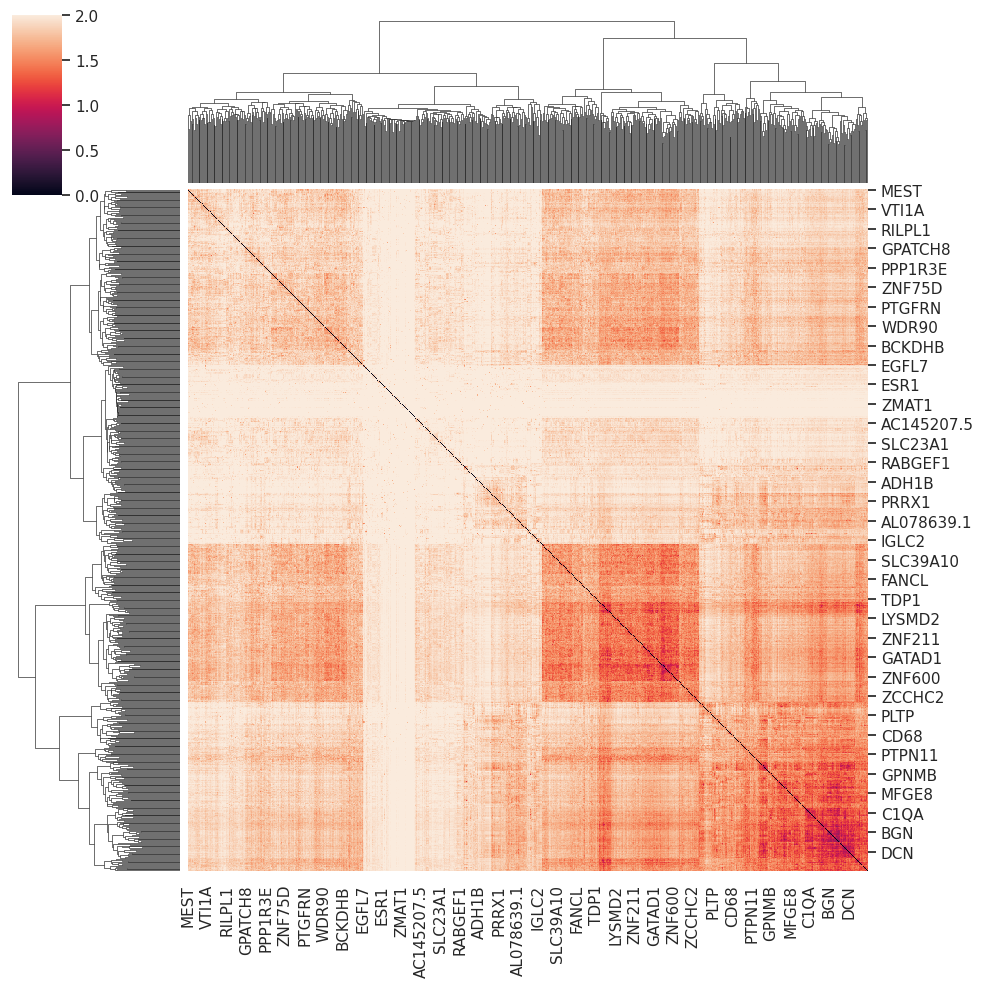

In [52]:
# Visualise the distance map to deside on the number of clusters:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.clustermap(sp.genes_distance_array)

# make it larger so labels/dendrograms aren’t cramped
g.figure.set_size_inches(14, 14)

# High-res raster
g.figure.savefig("/mnt/c/Users/Lefteris/Downloads/STMiner_test/results/stminer_genes_distance_clustermap.png", dpi=300, bbox_inches="tight")

# Vector
g.figure.savefig("/mnt/c/Users/Lefteris/Downloads/STMiner_test/results/stminer_genes_distance_clustermap.pdf", bbox_inches="tight")
g.figure.savefig("/mnt/c/Users/Lefteris/Downloads/STMiner_test/results/stminer_genes_distance_clustermap.svg", bbox_inches="tight")

plt.close(g.figure)  # tidy up

# plot the distance array here too
sns.clustermap(sp.genes_distance_array)

In [53]:
# Cluster gene patterns
sp.cluster_gene(n_clusters=2, mds_components=10)

In [54]:
sp.genes_labels

gene_id  labels
0      PCP4       1
1      APOD       1
2     CCL18       1
3     FXYD1       1
4       HBB       1
..      ...     ...
765   WHAMM       0
766  R3HDM2       0
767     DCK       0
768    PSAP       1
769    NWD1       0

[770 rows x 2 columns]

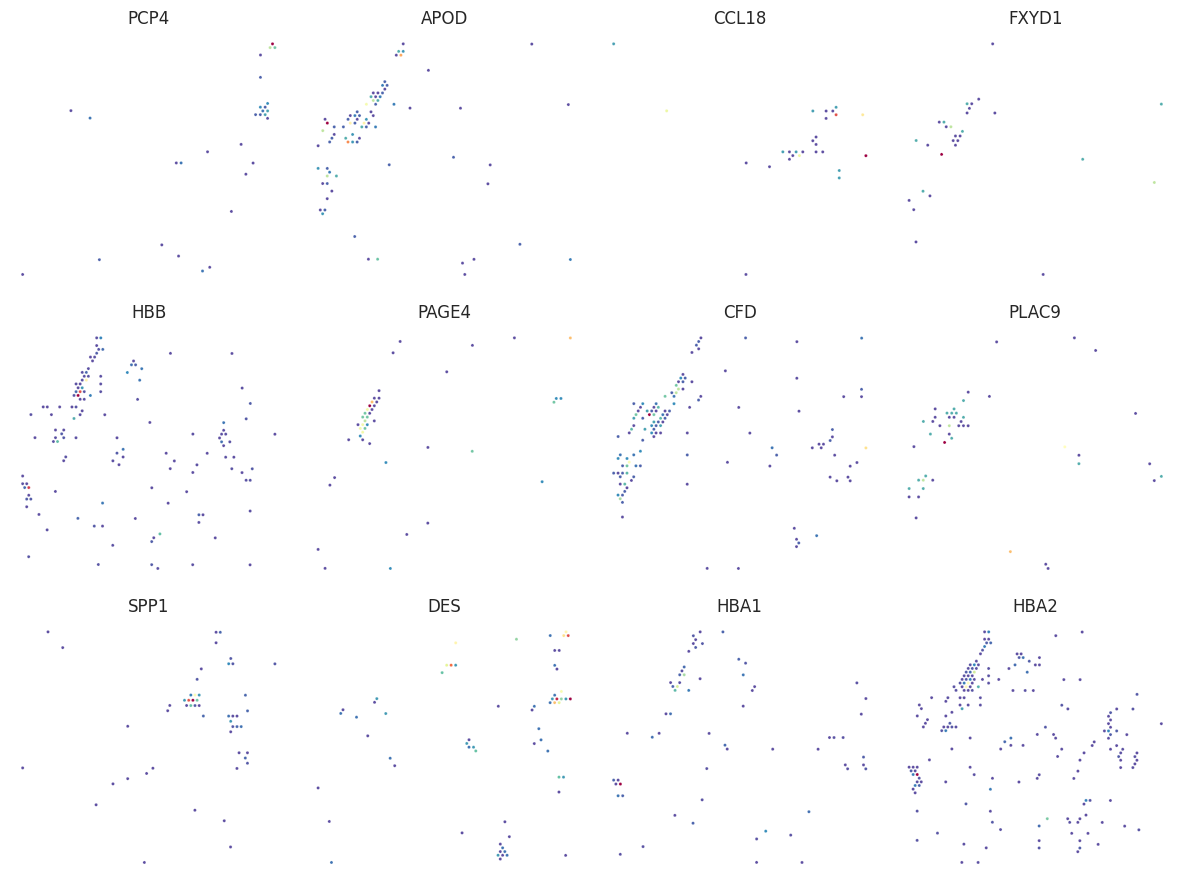

In [55]:
# Visualise the genes for each group
sp.plot.plot_genes(label=1, 
                   n_gene=12, 
                   s=5, 
                   reverse_y=False, 
                   reverse_x=False,
                   cmap="Spectral_r")

The following two code chunks are here in case we forget to change the index of the AnnData object from EnsgIDs to GeneNames at the beginning.

In [ ]:
# --- 1) Build a robust id->name mapping from the AnnData ---
#        Use it to rename the EnsgID instances to gene names in the sp object
# adata = sp.adata  # your AnnData

# Expect columns: 'gene_id' (ENSG...) and 'gene_name' (symbols)
# var_df = (
#     adata.var[['gene_id', 'gene_name']]
#     .dropna()
#     .astype(str)
#     .drop_duplicates(subset='gene_id')
# )

# create unique names if multiple ENSGs map to same symbol
# names = var_df['gene_name'].tolist()
# counts = pd.Series(names).groupby(names).cumcount().to_numpy()
# unique_names = np.where(counts == 0, names, [f"{n}__{i+1}" for n, i in zip(names, counts)])
# var_df['gene_name_unique'] = unique_names

# id_to_unique = pd.Series(var_df['gene_name_unique'].values, index=var_df['gene_id']).to_dict()

# sp.adata.var_names = sp.adata.var['gene_name'].to_numpy()

# --- 2) Helper to map any string ENSG to unique gene name ---
# def _map_id(x):
#     return id_to_unique.get(x, x) if isinstance(x, str) else x
# print(var_df)

In [ ]:
# --- 3) Rename keys in sp.patterns (dict[gene_id] -> dict[gene_name]) ---
# sp.patterns = { _map_id(k): v for k, v in sp.patterns.items() }

# --- 4) Update sp.global_distance (column 'Gene') ---
# df = sp.global_distance
# df['Gene'] = df['Gene'].astype(str).map(_map_id)

# --- 5) Update sp.genes_distance_array (rename index + columns) ---
# gda = sp.genes_distance_array
# gda.rename(index=id_to_unique, columns=id_to_unique, inplace=True)

# --- 6) Update sp.genes_labels ---
# gl = sp.genes_labels
# gl['gene_id'] = gl['gene_id'].astype(str).map(_map_id)


In [17]:
# -------- 8) Quick sanity prints (optional) --------
# The AnnData Object used
print(sp.adata)
print("\nExamples from adata.var_names:", list(sp.adata.var_names[:5]), "\n")

# A Pandas DataFrame representing the distances between each gene's spatial distribution and the overall tissue distribution (background)
if hasattr(sp, "global_distance"):
    print("global_distance head:\n", sp.global_distance.head(), "\n")

# A Pandas DataFrame storing the distances between the spatial distribution of each gene and the background
if hasattr(sp, "genes_distance_array"):
    print("genes_distance_array shape:", sp.genes_distance_array.shape, "\n")
    print(sp.genes_distance_array.head(), "\n")

# A Pandas DataFrame containing the gene names and their assigned pattern labels after clustering
if hasattr(sp, "genes_labels"):
    print("genes_labels head:\n", sp.genes_labels.head(), "\n")

# An array containing the embedded features of genes after multidimensional scaling (MDS) for visualization and clustering
print("Multi Dimensional Scaling (MDS):\n", sp.mds_features, "\n")

# A dictionary containing the spatial distribution patterns of genes
print("sp.patterns:\n", sp.patterns)

AnnData object with n_obs × n_vars = 3231 × 2458
    obs: 'barcode', 'label', 'region', 'spot_id', 'x', 'y', 'n_genes'
    var: 'gene_id', 'gene_name', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatialdata_attrs', 'hvg'
    obsm: 'spatial'
    layers: 'logcounts'

Examples from adata.var_names: ['NOC2L', 'ISG15', 'MXRA8', 'AURKAIP1', 'CCNL2'] 

global_distance head:
        Gene      Distance   z-score
2445   PCP4  1.338811e+07  3.276439
539    APOD  1.138840e+07  3.131812
1982  CCL18  8.456251e+06  2.865671
2283  FXYD1  8.128889e+06  2.830374
1261    HBB  7.967744e+06  2.812473 

genes_distance_array shape: (770, 770) 

           PCP4      APOD     CCL18     FXYD1       HBB     PAGE4       CFD  \
PCP4   0.000000  1.994552  1.893474  1.999112  1.830989  1.905887  1.897453   
APOD   1.994552  0.000000  1.996009  1.518201  1.712976  1.760482  0.992935   
CCL18  1.893474  1.996009  0.000000  1.999998  1.950431  1.994026  1.9384

In [56]:
# A vote_rate=0.2 means that within a cluster 20% of genes must share significant part of coordinates.
# It is possible that with sparse signals, almost no coordinates are shared by ≥20% of genes.
# Start with vote_rate=0.01 to test the plumbing.
sp.get_pattern_array(vote_rate=0.05, mode='vote')

Accumulating gene expression...: 100%|██████████| 276/276 [03:24<00:00,  1.35it/s]


In [57]:
# This is used to check if the vote has been too strict

import numpy as np
from scipy import sparse

label = 0
total_count = sp.patterns_matrix_dict[label]
print('type:', type(total_count), 'shape:', getattr(total_count, 'shape', None))

if sparse.issparse(total_count):
    print('nnz (non-zeros):', total_count.nnz)
    print('all_zero:', total_count.nnz == 0)
    if total_count.nnz:
        print('min/max:', total_count.data.min(), total_count.data.max())
else:
    arr = np.asarray(total_count)
    nnz = np.count_nonzero(arr)
    print('non-zeros:', nnz)
    print('all_zero:', nnz == 0)
    if nnz:
        print('min/max:', arr.min(), arr.max())


type: <class 'numpy.ndarray'> shape: (9012, 8721)
non-zeros: 100
all_zero: False
min/max: 0.0 4.4865551095168864e+148


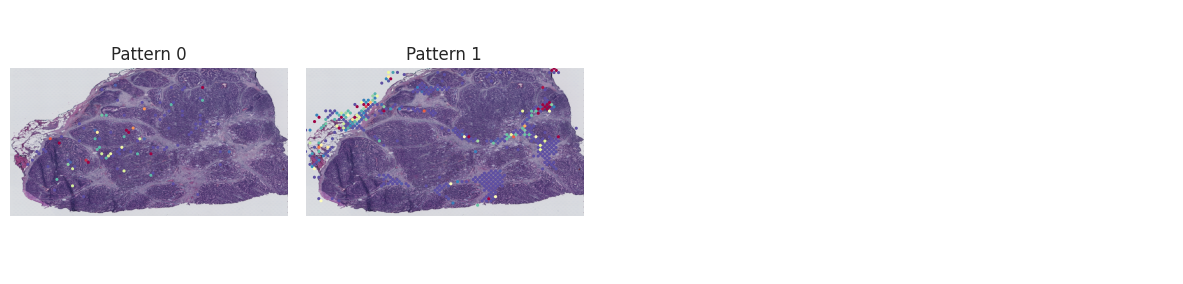

In [58]:
# heatmap: If True, plot a heatmap. If False, plot a scatterplot. False is the default.
# s: Spot size
# rotate\reverse_y\reverse_x: Adjust the axis of plot.
# cmap: cmap of plot
# vmax: The percentage of the highest value of plots. Avoid the effect of large values for visualization.
# output_path: If set, save the figure to path

sp.plot.plot_pattern(
    heatmap=False,
    s=5,
    rotate=False,
    reverse_y=False,
    reverse_x=False,
    vmax=95,
    cmap="Spectral_r",
    aspect=.55,
    image_path=img,
    rotate_img=False
)

The following code chunk will check for combinations of clusters and vote rates. The cluster combinations selected are 2, 4, and 8 according to the distance dendogram created earlier.


n_clusters=2 | vote_rate=0.0
--------------------------------------------------------------------------------


Accumulating gene expression...: 100%|██████████| 486/486 [05:55<00:00,  1.37it/s]


label=0  type=     ndarray  shape=(9012, 8721)  nnz=  2536  all_zero=False  min/max=0.0 / 8.883280265545402e+86
label=1  type=     ndarray  shape=(9012, 8721)  nnz=  2564  all_zero=False  min/max=0.0 / 1.1917412009627366e+148
→ Plotting remaining 2 labels to: /mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots/pattern_n2_vr0p00ppng


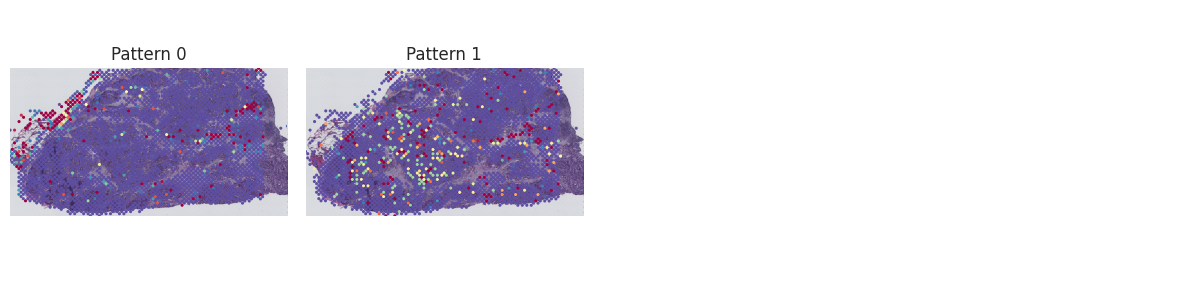


n_clusters=2 | vote_rate=0.05
--------------------------------------------------------------------------------


Accumulating gene expression...: 100%|██████████| 492/492 [05:58<00:00,  1.37it/s]


label=0  type=     ndarray  shape=(9012, 8721)  nnz=   456  all_zero=False  min/max=0.0 / 1.3880125414921574e+85
label=1  type=     ndarray  shape=(9012, 8721)  nnz=    97  all_zero=False  min/max=0.0 / 1.1216387773773253e+148
→ Plotting remaining 2 labels to: /mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots/pattern_n2_vr0p05ppng


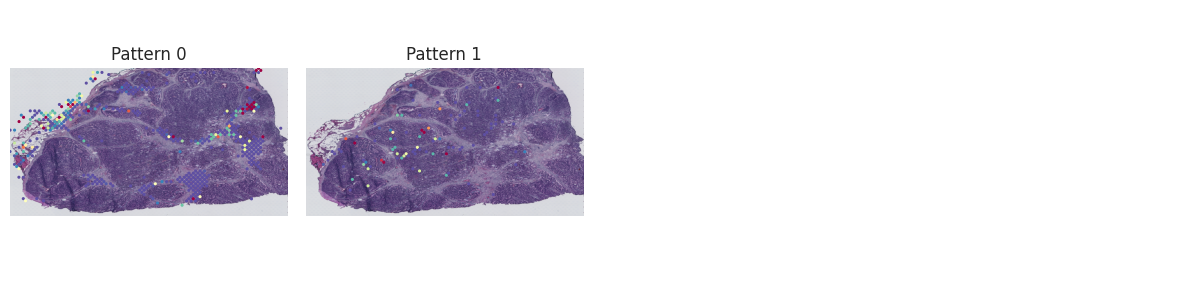


n_clusters=2 | vote_rate=0.1
--------------------------------------------------------------------------------


Accumulating gene expression...: 100%|██████████| 282/282 [03:27<00:00,  1.36it/s]


label=0  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=1  type=     ndarray  shape=(9012, 8721)  nnz=   278  all_zero=False  min/max=0.0 / 4.149690667916892e+85
Patched labels (no real signal; injected sentinel): [0]
→ Plotting remaining 2 labels to: /mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots/pattern_n2_vr0p10ppng


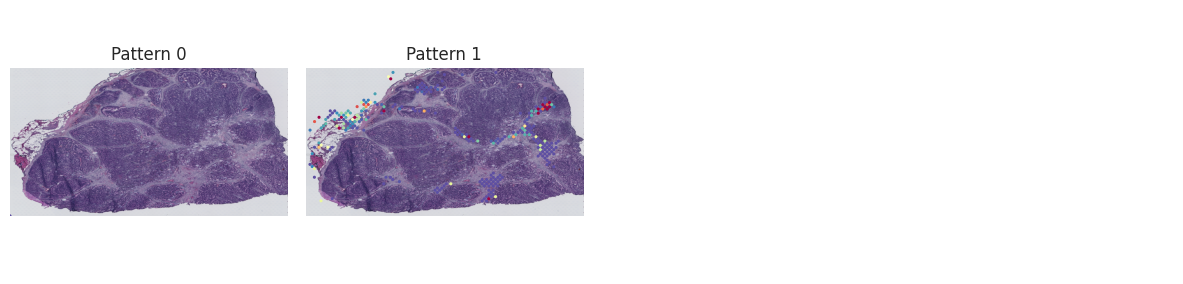


n_clusters=2 | vote_rate=0.15
--------------------------------------------------------------------------------


Accumulating gene expression...: 100%|██████████| 490/490 [06:01<00:00,  1.35it/s]


label=0  type=     ndarray  shape=(9012, 8721)  nnz=   169  all_zero=False  min/max=0.0 / 8.649596322844894e+84
label=1  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
Patched labels (no real signal; injected sentinel): [1]
→ Plotting remaining 2 labels to: /mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots/pattern_n2_vr0p15ppng


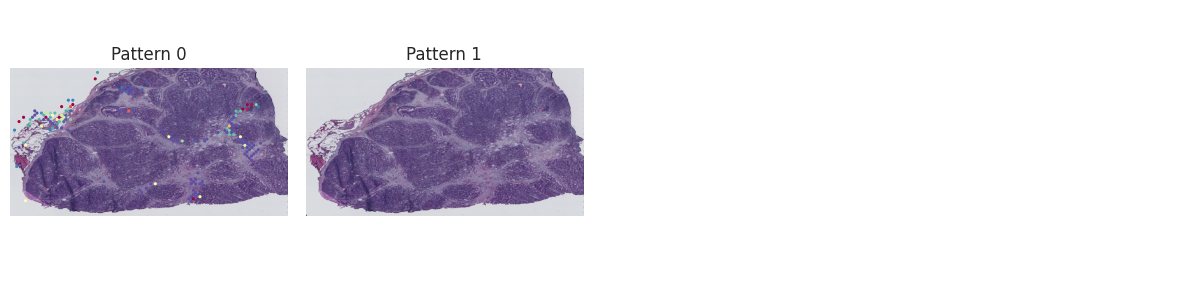


n_clusters=2 | vote_rate=0.2
--------------------------------------------------------------------------------


Accumulating gene expression...: 100%|██████████| 484/484 [05:54<00:00,  1.37it/s]


label=0  type=     ndarray  shape=(9012, 8721)  nnz=    84  all_zero=False  min/max=0.0 / 3.998955819270659e+86
label=1  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
Patched labels (no real signal; injected sentinel): [1]
→ Plotting remaining 2 labels to: /mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots/pattern_n2_vr0p20ppng


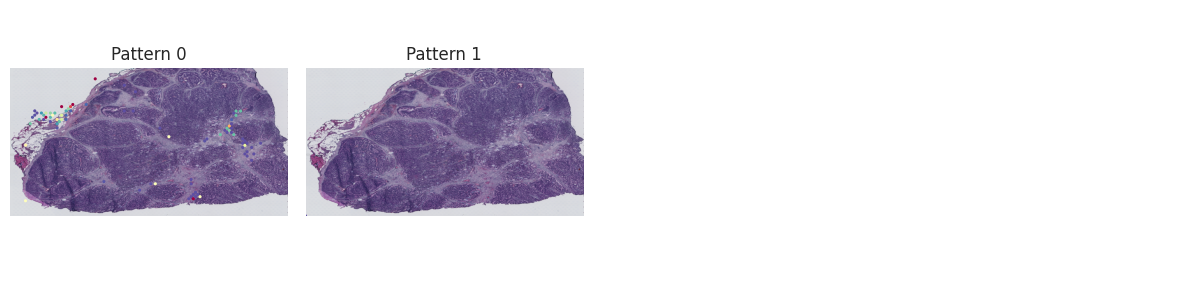


n_clusters=2 | vote_rate=0.3
--------------------------------------------------------------------------------


Accumulating gene expression...: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


label=0  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=1  type=     ndarray  shape=(9012, 8721)  nnz=     8  all_zero=False  min/max=0.0 / 2.7173784310416335e+83
Patched labels (no real signal; injected sentinel): [0]
→ Plotting remaining 2 labels to: /mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots/pattern_n2_vr0p30ppng


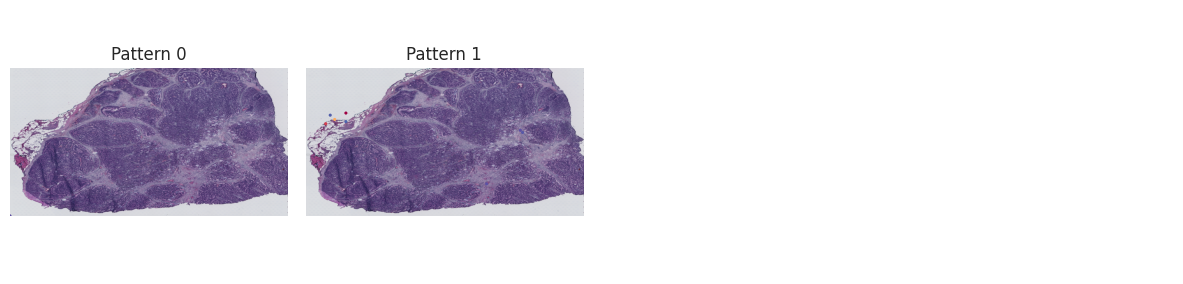


n_clusters=4 | vote_rate=0.0
--------------------------------------------------------------------------------


Accumulating gene expression...: 100%|██████████| 162/162 [01:59<00:00,  1.35it/s]


label=0  type=     ndarray  shape=(9012, 8721)  nnz=  2377  all_zero=False  min/max=0.0 / 1.532388095941209e+63
label=1  type=     ndarray  shape=(9012, 8721)  nnz=  1415  all_zero=False  min/max=0.0 / 8.209756315877552e+46
label=2  type=     ndarray  shape=(9012, 8721)  nnz=  2669  all_zero=False  min/max=0.0 / 3.65600022689065e+76
label=3  type=     ndarray  shape=(9012, 8721)  nnz=  1432  all_zero=False  min/max=0.0 / 1.747901446241807e+50
→ Plotting remaining 4 labels to: /mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots/pattern_n4_vr0p00ppng


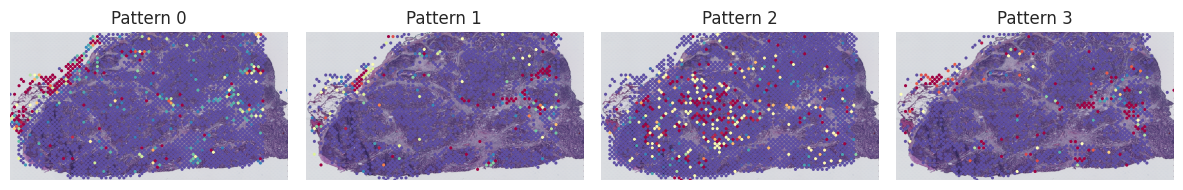


n_clusters=4 | vote_rate=0.05
--------------------------------------------------------------------------------


Accumulating gene expression...: 100%|██████████| 161/161 [01:59<00:00,  1.35it/s]


label=0  type=     ndarray  shape=(9012, 8721)  nnz=     6  all_zero=False  min/max=0.0 / 4.496117986665375e+42
label=1  type=     ndarray  shape=(9012, 8721)  nnz=   505  all_zero=False  min/max=0.0 / 6.23957372126144e+78
label=2  type=     ndarray  shape=(9012, 8721)  nnz=   502  all_zero=False  min/max=0.0 / 1.5323880959434999e+63
label=3  type=     ndarray  shape=(9012, 8721)  nnz=    22  all_zero=False  min/max=0.0 / 1.1546532248769488e+49
→ Plotting remaining 4 labels to: /mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots/pattern_n4_vr0p05ppng


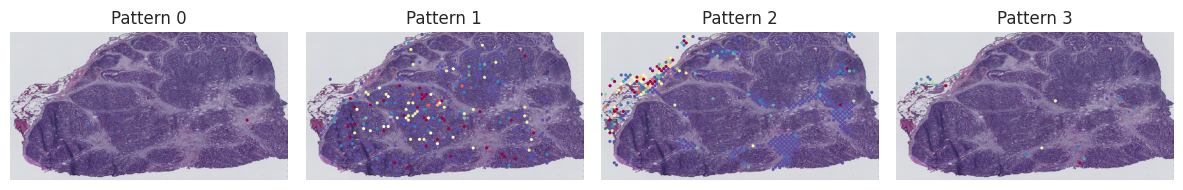


n_clusters=4 | vote_rate=0.1
--------------------------------------------------------------------------------


Accumulating gene expression...: 100%|██████████| 261/261 [03:11<00:00,  1.36it/s]


label=0  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=1  type=     ndarray  shape=(9012, 8721)  nnz=   347  all_zero=False  min/max=0.0 / 8.772997826472987e+63
label=2  type=     ndarray  shape=(9012, 8721)  nnz=     1  all_zero=False  min/max=0.0 / 3.1197522611473293e+44
label=3  type=     ndarray  shape=(9012, 8721)  nnz=    20  all_zero=False  min/max=0.0 / 4.0718101589505475e+78
Patched labels (no real signal; injected sentinel): [0]
→ Plotting remaining 4 labels to: /mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots/pattern_n4_vr0p10ppng


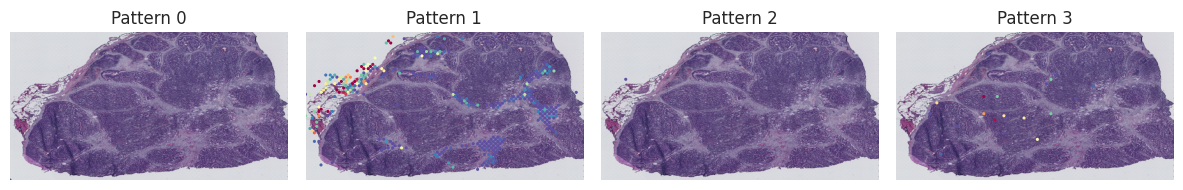


n_clusters=4 | vote_rate=0.15
--------------------------------------------------------------------------------


Accumulating gene expression...: 100%|██████████| 162/162 [01:59<00:00,  1.36it/s]


label=0  type=     ndarray  shape=(9012, 8721)  nnz=   238  all_zero=False  min/max=0.0 / 2.7415624105501674e+62
label=1  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=2  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=3  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
Patched labels (no real signal; injected sentinel): [1, 2, 3]
→ Plotting remaining 4 labels to: /mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots/pattern_n4_vr0p15ppng


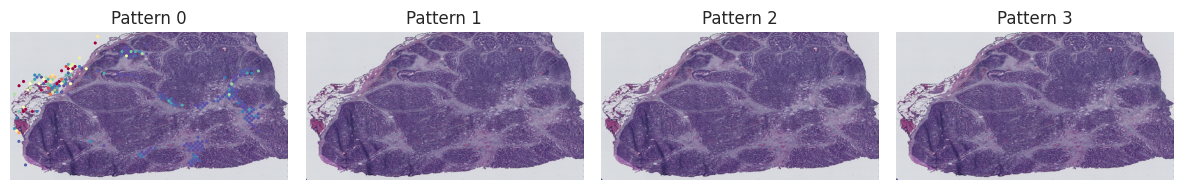


n_clusters=4 | vote_rate=0.2
--------------------------------------------------------------------------------


Accumulating gene expression...: 100%|██████████| 262/262 [03:10<00:00,  1.37it/s]


label=0  type=     ndarray  shape=(9012, 8721)  nnz=   147  all_zero=False  min/max=0.0 / 2.173911983638654e+63
label=1  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=2  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=3  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
Patched labels (no real signal; injected sentinel): [1, 2, 3]
→ Plotting remaining 4 labels to: /mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots/pattern_n4_vr0p20ppng


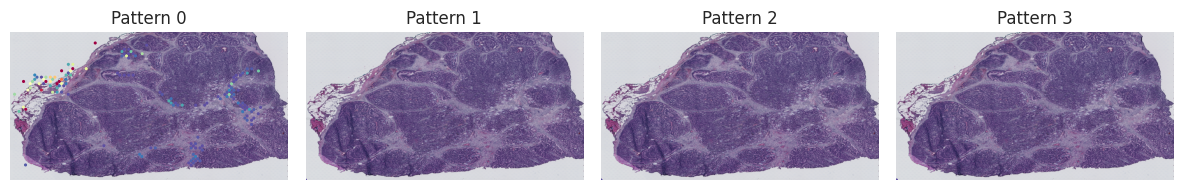


n_clusters=4 | vote_rate=0.3
--------------------------------------------------------------------------------


Accumulating gene expression...: 100%|██████████| 143/143 [01:46<00:00,  1.34it/s]


label=0  type=     ndarray  shape=(9012, 8721)  nnz=    34  all_zero=False  min/max=0.0 / 1.860344027883562e+62
label=1  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=2  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=3  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
Patched labels (no real signal; injected sentinel): [1, 2, 3]
→ Plotting remaining 4 labels to: /mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots/pattern_n4_vr0p30ppng


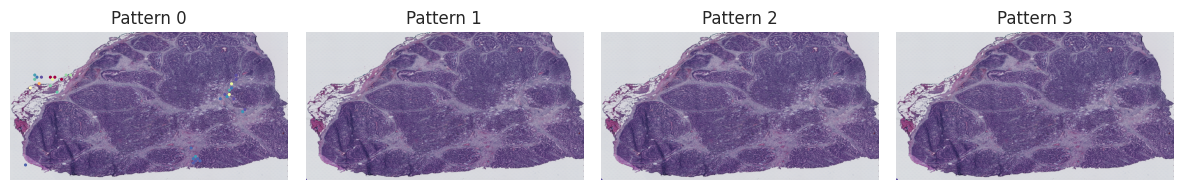


n_clusters=8 | vote_rate=0.0
--------------------------------------------------------------------------------


Accumulating gene expression...: 100%|██████████| 164/164 [02:00<00:00,  1.36it/s]


label=0  type=     ndarray  shape=(9012, 8721)  nnz=  1121  all_zero=False  min/max=0.0 / 6.375247890642957e+23
label=1  type=     ndarray  shape=(9012, 8721)  nnz=  1269  all_zero=False  min/max=0.0 / 3.8685626227668134e+27
label=2  type=     ndarray  shape=(9012, 8721)  nnz=   846  all_zero=False  min/max=0.0 / 8.802656821138593e+21
label=3  type=     ndarray  shape=(9012, 8721)  nnz=   811  all_zero=False  min/max=0.0 / 8.383699535022108e+23
label=4  type=     ndarray  shape=(9012, 8721)  nnz=  2560  all_zero=False  min/max=0.0 / 3.38040160133513e+33
label=5  type=     ndarray  shape=(9012, 8721)  nnz=  1084  all_zero=False  min/max=0.0 / 8.153955531125857e+25
label=6  type=     ndarray  shape=(9012, 8721)  nnz=  2000  all_zero=False  min/max=0.0 / 2.623051525315557e+34
label=7  type=     ndarray  shape=(9012, 8721)  nnz=  2348  all_zero=False  min/max=0.0 / 4.015009529074227e+50
→ Plotting remaining 8 labels to: /mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots/pat

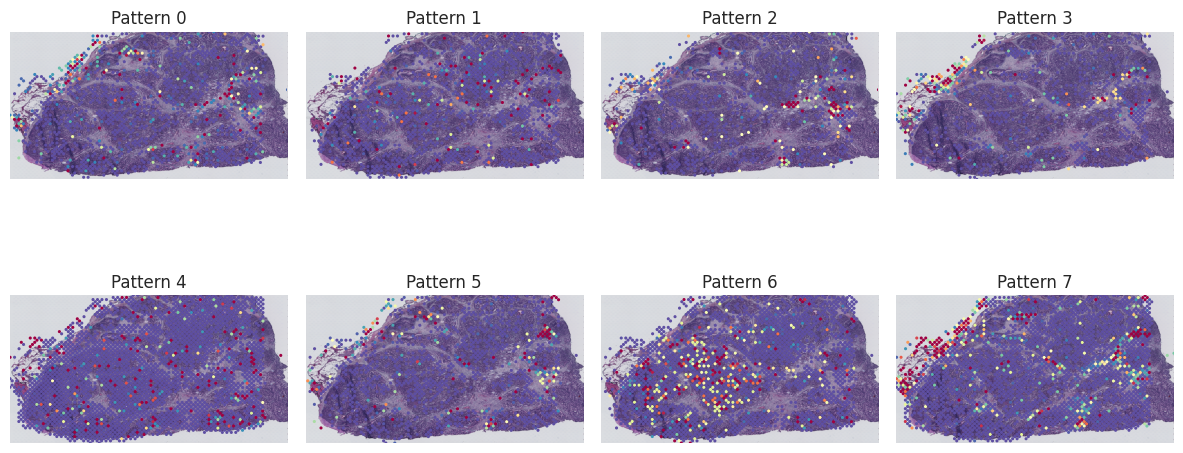


n_clusters=8 | vote_rate=0.05
--------------------------------------------------------------------------------


Accumulating gene expression...: 100%|██████████| 121/121 [01:28<00:00,  1.36it/s]


label=0  type=     ndarray  shape=(9012, 8721)  nnz=   138  all_zero=False  min/max=0.0 / 1.1258288292147083e+24
label=1  type=     ndarray  shape=(9012, 8721)  nnz=   539  all_zero=False  min/max=0.0 / 6.904789416849847e+52
label=2  type=     ndarray  shape=(9012, 8721)  nnz=   193  all_zero=False  min/max=0.0 / 2.138430153704015e+23
label=3  type=     ndarray  shape=(9012, 8721)  nnz=    31  all_zero=False  min/max=0.0 / 1.6404009887863664e+24
label=4  type=     ndarray  shape=(9012, 8721)  nnz=   365  all_zero=False  min/max=0.0 / 8.004917995704445e+29
label=5  type=     ndarray  shape=(9012, 8721)  nnz=    58  all_zero=False  min/max=0.0 / 3.1813837578055465e+24
label=6  type=     ndarray  shape=(9012, 8721)  nnz=    46  all_zero=False  min/max=0.0 / 2.4772847898497657e+23
label=7  type=     ndarray  shape=(9012, 8721)  nnz=   771  all_zero=False  min/max=0.0 / 9.881574144154796e+36
→ Plotting remaining 8 labels to: /mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots

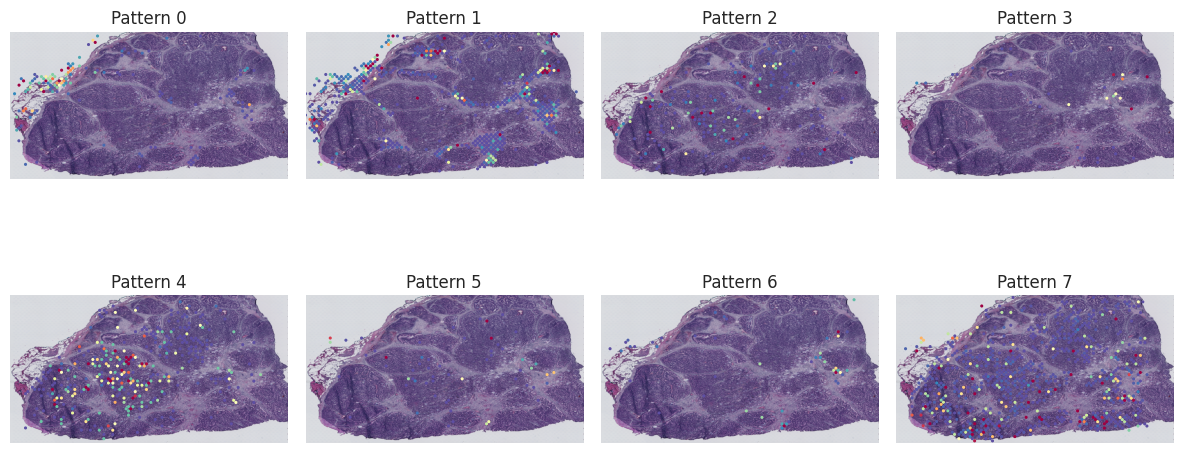


n_clusters=8 | vote_rate=0.1
--------------------------------------------------------------------------------


Accumulating gene expression...: 100%|██████████| 99/99 [01:11<00:00,  1.38it/s]


label=0  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=1  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=2  type=     ndarray  shape=(9012, 8721)  nnz=   149  all_zero=False  min/max=0.0 / 6.695171940459627e+29
label=3  type=     ndarray  shape=(9012, 8721)  nnz=    25  all_zero=False  min/max=0.0 / 5.076159080275595e+22
label=4  type=     ndarray  shape=(9012, 8721)  nnz=   382  all_zero=False  min/max=0.0 / 1.605151365680109e+51
label=5  type=     ndarray  shape=(9012, 8721)  nnz=    56  all_zero=False  min/max=0.0 / 8.705617627729424e+32
label=6  type=     ndarray  shape=(9012, 8721)  nnz=     3  all_zero=False  min/max=0.0 / 2.3081836050443173e+27
label=7  type=     ndarray  shape=(9012, 8721)  nnz=     8  all_zero=False  min/max=0.0 / 8.595355045156099e+27
Patched labels (no real signal; injected sentinel): [0, 1]
→ Plotting remaining 8 labels to: /mnt/c/Users/Lefteris/Downloads/STMiner_te

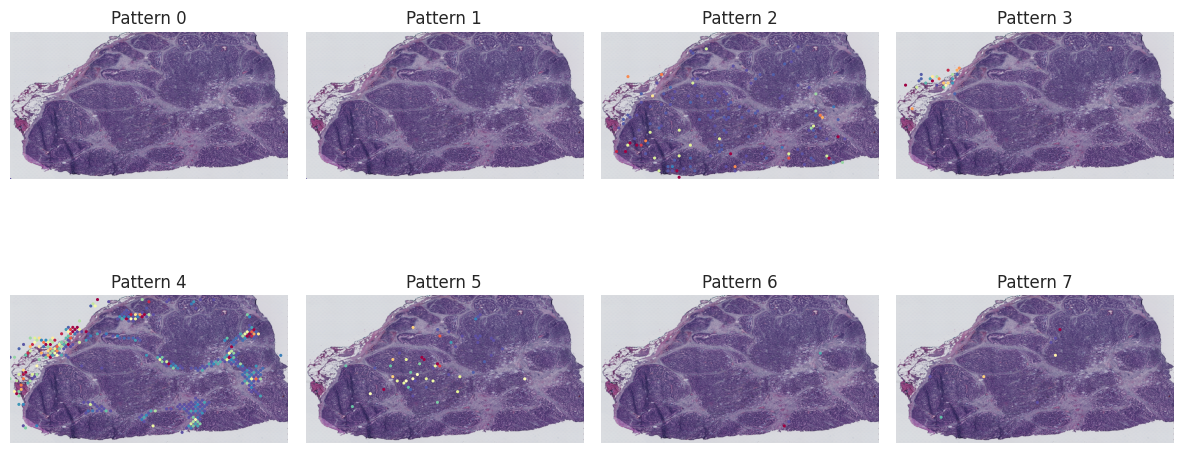


n_clusters=8 | vote_rate=0.15
--------------------------------------------------------------------------------


Accumulating gene expression...: 100%|██████████| 155/155 [01:52<00:00,  1.38it/s]


label=0  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=1  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=2  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=3  type=     ndarray  shape=(9012, 8721)  nnz=    26  all_zero=False  min/max=0.0 / 6.864542138355569e+22
label=4  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=5  type=     ndarray  shape=(9012, 8721)  nnz=     4  all_zero=False  min/max=0.0 / 9.036440234280488e+49
label=6  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=7  type=     ndarray  shape=(9012, 8721)  nnz=   281  all_zero=False  min/max=0.0 / 8.179825859012254e+47
Patched labels (no real signal; injected sentinel): [0, 1, 2, 4, 6]
→ Plotting remaining 8 labels to: /mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots/pattern_n8_vr0p

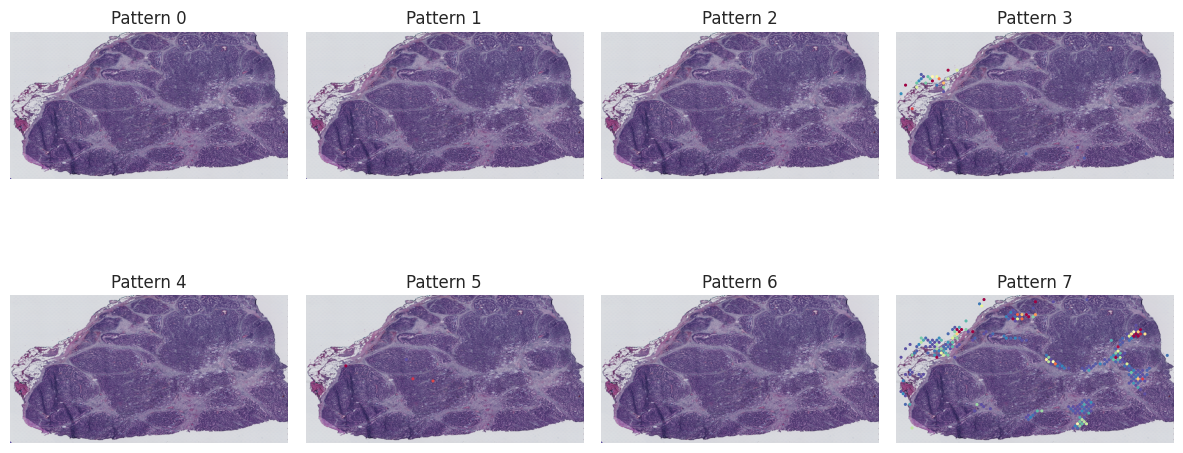


n_clusters=8 | vote_rate=0.2
--------------------------------------------------------------------------------


Accumulating gene expression...: 100%|██████████| 72/72 [00:53<00:00,  1.35it/s]


label=0  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=1  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=2  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=3  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=4  type=     ndarray  shape=(9012, 8721)  nnz=   189  all_zero=False  min/max=0.0 / 1.7131881086821236e+51
label=5  type=     ndarray  shape=(9012, 8721)  nnz=     1  all_zero=False  min/max=0.0 / 3.7890946658699684e+22
label=6  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=7  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
Patched labels (no real signal; injected sentinel): [0, 1, 2, 3, 6, 7]
→ Plotting remaining 8 labels to: /mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots/pattern_n8_vr0p20ppng


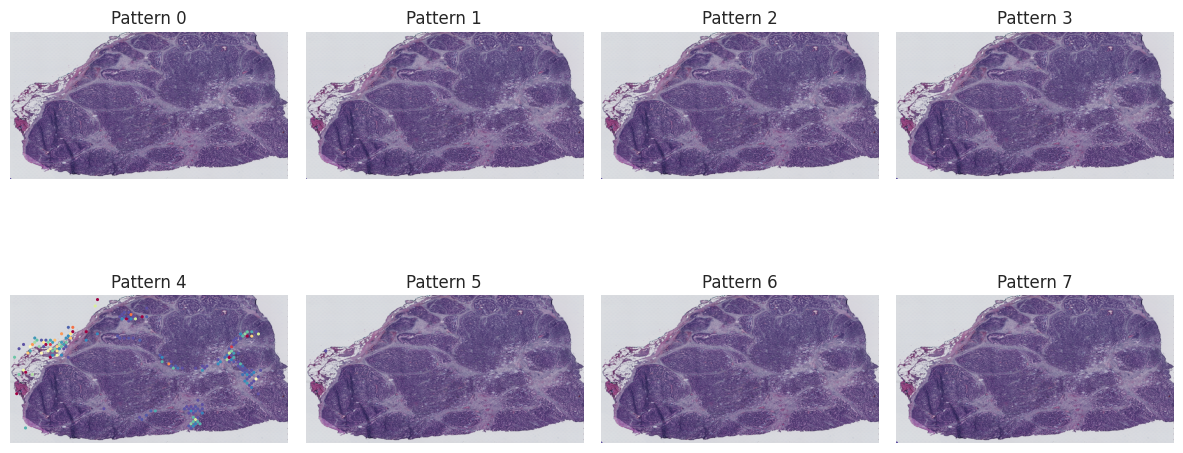


n_clusters=8 | vote_rate=0.3
--------------------------------------------------------------------------------


Accumulating gene expression...: 100%|██████████| 79/79 [00:58<00:00,  1.36it/s]


label=0  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=1  type=     ndarray  shape=(9012, 8721)  nnz=    71  all_zero=False  min/max=0.0 / 1.0032191748293017e+50
label=2  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=3  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=4  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=5  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=6  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
label=7  type=     ndarray  shape=(9012, 8721)  nnz=     0  all_zero= True  min/max=None / None
Patched labels (no real signal; injected sentinel): [0, 2, 3, 4, 5, 6, 7]
→ Plotting remaining 8 labels to: /mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots/pattern_n8_vr0p30ppng


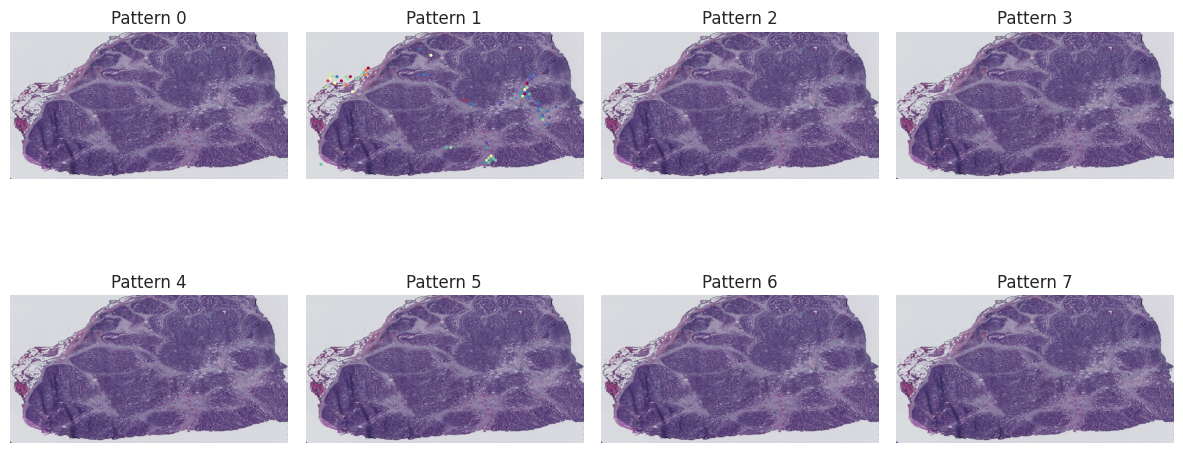

In [76]:
from itertools import product
import os
import numpy as np
try:
    from scipy import sparse
    _HAVE_SCIPY = True
except Exception:
    _HAVE_SCIPY = False



# -----------------------------------------
# Config
# -----------------------------------------
clusters = [2, 4, 8]
vote_rates = [0.0, 0.05, 0.1, 0.15, 0.2, 0.3]
mds_components = 10
EPS = 1e-12  # tiny sentinel value so that every pattern has at least one 
             # non-zero value → csr_matrix(...).data is non-empty → 
             # np.percentile(..., vmax) doesn’t error. 

# Plot settings
PLOT_KW = dict(
    heatmap=False,
    s=5,
    rotate=False,
    reverse_y=False,
    reverse_x=False,
    vmax=95,
    cmap="Spectral_r",
    aspect=.55,
    image_path=img,
    rotate_img=False
)

# Output directory for plots
outdir = "/mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots"
os.makedirs(outdir, exist_ok=True)

# -----------------------------------------
# Helper: summarise per-label matrix
# -----------------------------------------
def _summarise_total_count(total_count):
    """
    Returns a dict with:
      - type
      - shape
      - nnz
      - all_zero
      - vmin
      - vmax
    Handles dense and scipy.sparse matrices.
    """
    summary = {
        "type": type(total_count).__name__,
        "shape": getattr(total_count, "shape", None),
        "nnz": None,
        "all_zero": None,
        "vmin": None,
        "vmax": None,
        "sparse": False
    }

    if _HAVE_SCIPY and sparse.issparse(total_count):
        summary["sparse"] = True
        nnz = int(total_count.nnz)
        summary["nnz"] = nnz
        summary["all_zero"] = (nnz == 0)
        if nnz:
            data = total_count.data
            summary["vmin"] = float(data.min())
            summary["vmax"] = float(data.max())
    else:
        arr = np.asarray(total_count)
        nnz = int(np.count_nonzero(arr))
        summary["nnz"] = nnz
        summary["all_zero"] = (nnz == 0)
        if nnz:
            summary["vmin"] = float(arr.min())
            summary["vmax"] = float(arr.max())
    return summary


# -----------------------------------------
# Helper: check all labels for current state
# -----------------------------------------
def check_vote_strictness_all_labels(sp_obj):
    """
    Inspects sp.patterns_matrix_dict for ALL labels.
    Returns:
        summary: dict[label] -> summary dict
        all_clear: True if every label has all_zero == False
    """
    summary = {}
    for label in sorted(sp_obj.patterns_matrix_dict.keys()):
        summary[label] = _summarise_total_count(sp_obj.patterns_matrix_dict[label])
    return summary

# -----------------------------------------
# Helper: create and enforce dummy matrix when needed
# -----------------------------------------
def _dummy_like(arr, eps=EPS):
    """Return a matrix with the same shape/type as arr, with a single tiny non-zero at (0,0)."""
    shape = getattr(arr, "shape", None)
    if shape is None or shape[0] == 0 or shape[1] == 0:
        raise ValueError("Pattern matrix has invalid shape for dummy injection.")
    if _HAVE_SCIPY and sparse.issparse(arr):
        # CSR with one entry at (0,0)
        return sparse.csr_matrix(([float(eps)], ([0], [0])), shape=shape)
    out = np.zeros(shape, dtype=float)
    out[0, 0] = float(eps)
    return out

def enforce_nonzero_for_plot(sp_obj, results, eps=EPS):
    """
    For any label with all_zero=True, replace its matrix with a tiny sentinel value.
    Returns the list of patched labels.
    """
    patched = []
    for lbl, r in results.items():
        if r["all_zero"]:
            tc = sp_obj.patterns_matrix_dict[lbl]
            sp_obj.patterns_matrix_dict[lbl] = _dummy_like(tc, eps=eps)
            patched.append(lbl)
    return patched

# -----------------------------------------
# Main loop
# -----------------------------------------
for nclust, vr in product(clusters, vote_rates):
    print("\n" + "="*80)
    print(f"n_clusters={nclust} | vote_rate={vr}")
    print("-"*80)

    # 1) cluster
    sp.cluster_gene(n_clusters=nclust, mds_components=mds_components)

    # 2) build vote arrays
    sp.patterns_matrix_dict.clear()
    sp.patterns_binary_matrix_dict.clear()
    sp.get_pattern_array(vote_rate=vr, mode='vote')

    # 3) check strictness across ALL labels
    summary = check_vote_strictness_all_labels(sp)

    # Pretty print diagnostics per label
    for label in sorted(summary.keys()):
        r = summary[label]
        print(
            f"label={label}  type={r['type']:>12}  shape={r['shape']}  "
            f"nnz={r['nnz']:>6}  all_zero={str(r['all_zero']):>5}  "
            f"min/max={r['vmin']} / {r['vmax']}"
        )

    # 4) Patch zero-signal labels and plot the remainder
    # Patch all-zero labels with a dummy so plot_pattern won’t crash
    patched_labels = enforce_nonzero_for_plot(sp, summary, eps=EPS)
    if patched_labels:
        print(f"Patched labels (no real signal; injected sentinel): {patched_labels}")

    # Proceed to plot — all labels now have at least one non-zero entry
    # Build image path
    fname = f"pattern_n{nclust}_vr{vr:.2f}.png".replace(".", "p")
    img_path = os.path.join(outdir, fname)
    print(f"→ Plotting remaining {len(sp.patterns_matrix_dict)} labels to: {img_path}")

    sp.plot.plot_pattern(
        output_path=img_path,
        **PLOT_KW
    )


After running the combination of clusters and vote rates to identify patterns, we have selected to keep the n_cluster = 8 and vote_rate_0.05 because it gives wider patterns.

In [ ]:
nclust = 8
mds_components = 10
vr=0.05
gene_cluster_path="/mnt/c/Users/Lefteris/Downloads/STMiner_test/results/stminer_gene_cluster.csv"

# 1) cluster
sp.cluster_gene(n_clusters=nclust, mds_components=mds_components)
gc = sp.genes_labels
gc.to_csv(gene_cluster_path)

# 2) build vote arrays
sp.patterns_matrix_dict.clear()
sp.patterns_binary_matrix_dict.clear()
sp.get_pattern_array(vote_rate=vr, mode='vote')

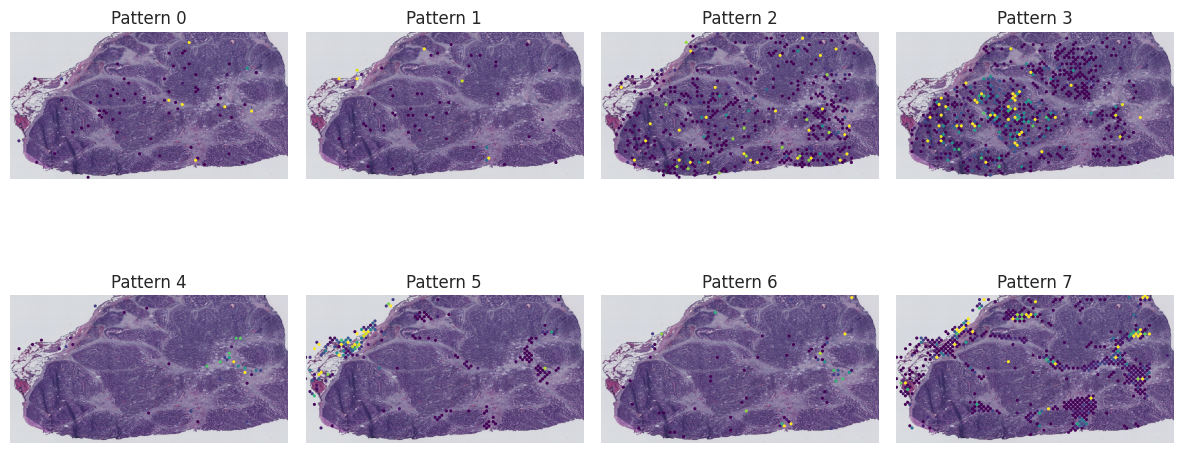

In [105]:
img2="/mnt/c/Users/Lefteris/Downloads/STMiner_test/data/H1_5/outs/spatial/tissue_lowres_image2.png"
outImg="/mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots/pattern_n8_vr0p05.png"
sp.plot.plot_pattern(
    heatmap=False,
    s=5,
    rotate=False,
    reverse_y=False,
    reverse_x=False,
    vmax=95,
    #cmap="Spectral_r",
    aspect=.55,
    image_path=img2,
    rotate_img=False,
    output_path=outImg
)

'/mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots/pattern_n8_vr0p05_lbl3vs7.png'

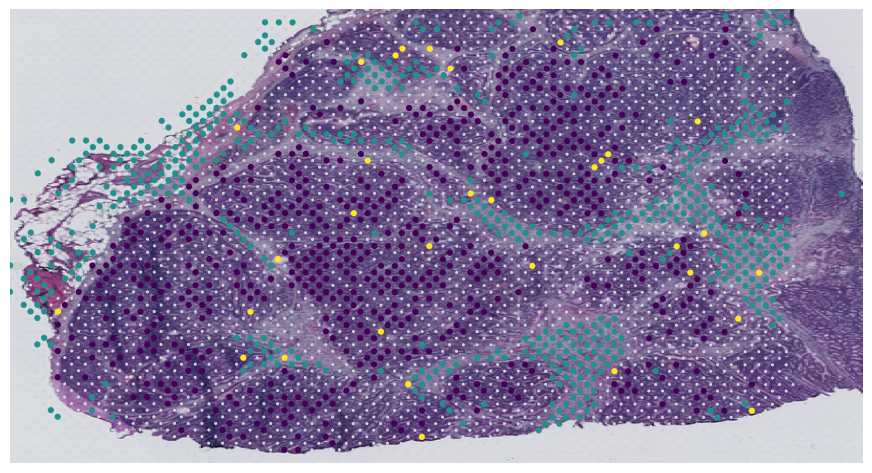

In [104]:
sp.plot.plot_intersection(pattern_list=[3, 7],
                          image_path=img2,
                          reverse_y=False,
                          reverse_x=False,
                          aspect=0.55,
                          figsize=(11,8),
                          s=20,
                          cmap="viridis",
)

# output: "/mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots/pattern_n8_vr0p05_lbl3vs7.png"

The below code was not used since no genes of particular interested existed at this point.

In [ ]:
interested_genes = ["mbpa", "BX957331.1", "madd"]
sp.get_pattern_of_given_genes(gene_list = interested_genes, n_comp=10)

In [ ]:
from STMiner.Algorithm.distance import compare_gmm_distance
df = compare_gmm_distance(sp.custom_pattern, sp.patterns)

In [ ]:
df

In [5]:
df.to_csv('compare_gmm_distance.csv')